In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
#export
from exp.nb_07a import *

# Data block API
## Load and explore data

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160')

In [6]:
#export
import PIL, os, mimetypes
Path.ls = lambda x: list(x.iterdir())

In [7]:
path.ls()

[PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/train'),
 PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/val')]

In [8]:
(path/"val").ls()

[PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/val/n03394916'),
 PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/val/n03417042'),
 PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/val/n03445777'),
 PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/val/n02102040'),
 PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/val/n03425413'),
 PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/val/n03888257'),
 PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/val/n03028079'),
 PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/val/n03000684'),
 PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/val/n01440764'),
 PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/val/n02979186')]

In [11]:
path_tench = path/"val"/"n01440764"

In [12]:
img_fn = path_tench.ls()[0]

In [13]:
img = PIL.Image.open(img_fn)

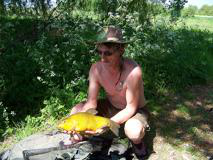

In [14]:
img

In [15]:
import numpy as np

In [16]:
img_arr = np.array(img)

In [18]:
img_arr.shape

(160, 213, 3)

In [19]:
img_arr[:10, :10, 0]

array([[ 13,  13,  23,  31, ...,  58,  63,  63,  59],
       [ 23,  17,   3,  28, ...,  52,  88,  59, 122],
       [ 25,   0,   7,  34, ..., 107,  72, 104, 135],
       [ 20,   8,  36,  41, ..., 191, 176, 110,  37],
       ...,
       [ 46,  38,  31,  30, ..., 140, 110,  48,  37],
       [ 66,  63,  21,  38, ..., 122, 141, 105,  15],
       [ 46,  56,  38,  22, ..., 105,  97, 108, 113],
       [ 40,  37,  22,   3, ..., 122, 168, 166, 153]], dtype=uint8)

We just want to keep the images. To filter those, we use `mimetypes`:

In [25]:
#export
image_extensions = set(k for k, v in mimetypes.types_map.items() if v.startswith("image/"))

In [27]:
' '.join(image_extensions)

'.ras .xwd .xpm .pgm .jpe .jpeg .png .gif .pnm .ico .bmp .jpg .ppm .svg .tiff .xbm .pbm .rgb .ief .tif'

In [28]:
#export
def setify(x):
    return x if isinstance(x, set) else set(listify(x))

In [37]:
test_eq(setify(["aa", 1]), {"aa", 1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

We (recursively) walk through all directories and grab all image files:

In [54]:
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [53]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/ILSVRC2012_val_00018317.JPEG'),
 PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/ILSVRC2012_val_00037383.JPEG'),
 PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/ILSVRC2012_val_00011233.JPEG')]

In [58]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

Reason we do it so complicated is that `os.scandir` is super fast.

In [59]:
get_files(path_tench, image_extensions)[:3]

[PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00018317.JPEG'),
 PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00037383.JPEG'),
 PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00011233.JPEG')]

We need the recurse argument when we start from path since the pictures are two level below in directories.

In [62]:
get_files(path, image_extensions, recurse=True)[:3]

[PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'),
 PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/train/n03394916/n03394916_32588.JPEG'),
 PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/train/n03394916/n03394916_32422.JPEG')]

In [63]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

Imagenet is 100x larger, this has to be fast!

In [64]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

70.6 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Prepare for modeling
What we need to do:

* Get files
* Split validation set
  * random %
  * folder name
  * csv, ...
* Label:
  * folder name
  * file name/re
  * csv, ...
* Transform per image (optional)
* Transform to tensor
* DataLoader
* Transform per batch (optional)
* DataBunch
* Add test set (optional)

### Get files

* We use `ListContainer` from notebook 06
* Overload `get` method to specify how to access an item, i.e. open an image.
* Private `_get` allows to apply a transform to it
* `new` will be used in conjunction with `__getitem__` (that works for one index or a list of indices) to create training and validation set from a single stream when we split the data.

In [69]:
??ListContainer

In [70]:
#export
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    
    # order the funcs with respect to their order_keys and apply them
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

In [74]:
#export
class ItemList(ListContainer):
    def __init__(self, items, path=".", tfms=None):
        super().__init__(items)
        self.path, self.tfms = path, tfms
        
    def __repr__(self):
        return f'{super().__repr__()}\n Path: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: cls = self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res, list): return [self._get(o) for o in res]
        return self._get(res)
        # we use _get so that the tfms are applied

In [91]:
#export
class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)

Transforms can be used not only for data augmentation but i.e. also for converting all loaded images to RGB.

They can be a function or a functor that take an item of `ItemList` and transform it. When they are a class, they can have an `_order` attribute.

In [92]:
#export
class Transform():
    _order = 0
    
class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')
    
def make_rgb(item): return item.convert('RGB')

In [97]:
il = ImageList.from_files(path, tfms=make_rgb)

In [98]:
il

ImageList (13394 items)
 [PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/train/n03394916/n03394916_32422.JPEG'), PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/train/n03394916/n03394916_33008.JP

In [81]:
??ListContainer

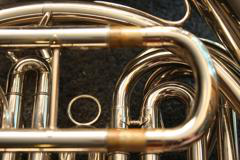

In [110]:
img = il[0]; img

Indexing with a range of integers:

In [102]:
il[:2]

[<PIL.Image.Image image mode=RGB size=240x160 at 0x1262EDF60>,
 <PIL.Image.Image image mode=RGB size=213x160 at 0x1262ED320>]

### Split validation set

In [111]:
fn = il.items[0]; fn  # il[0] would call _get and get and give image

PosixPath('/Users/fabiograetz/.fastai/data/imagenette-160/train/n03394916/n03394916_58454.JPEG')

In [113]:
fn.parent.parent.name

'train'

We split by the grandparent's name.

In [114]:
#export
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

In [118]:
#export
def split_by_func(items, f):
    mask = [f(o) for o in items]
    
    f = [o for o, m in zip(items, mask) if m==False]
    t = [o for o, m in zip(items, mask) if m==True ]
    
    return f,t

In [119]:
splitter = partial(grandparent_splitter, valid_name="val")

In [121]:
%time train, valid = split_by_func(il, splitter)

CPU times: user 35.7 ms, sys: 1.79 ms, total: 37.4 ms
Wall time: 37.1 ms


In [123]:
type(train)

list

In [124]:
len(train), len(valid)

(12894, 500)